In [1]:
from igraph import *
from pulp import LpMaximize, LpMinimize, LpProblem, LpStatus, lpSum, LpVariable
import numpy as np
import re
import timeit

import igraph
import networkx as nx
import pandas as pd
import random

In [2]:
def PreserveLargestConnectedGraph(G):
    Max = set()
    for S in list(nx.connected_components(G)):
        if len(S) > len(Max):
            Max = S
        else:
            G.remove_nodes_from(S)
    return G

In [3]:
raw_data = pd.read_csv('data/Contact-diaries-network_data_2013.csv',names=['userID', 'friendID','weight'])#, delimiter='\t', header=0, names=['userID', 'friendID','weight'],dtype={'userID': int, 'friendID': int,'weight': int})

In [4]:
raw_data

,userID,friendID,weight
0,3,28,2
1,3,106,1
2,3,147,4
3,3,177,1
4,3,295,4
...,...,...,...
497,1828,1237,1
498,1828,1295,1
499,1828,1412,1
500,1828,1423,2


In [5]:
len(pd.unique(raw_data['userID']))

119

In [6]:
G = nx.Graph()
subset =raw_data#[raw_data['weight']==1]
data = [(userID, friendID) for userID, friendID in zip(subset['userID'], subset['friendID'])]
G.add_edges_from(data)

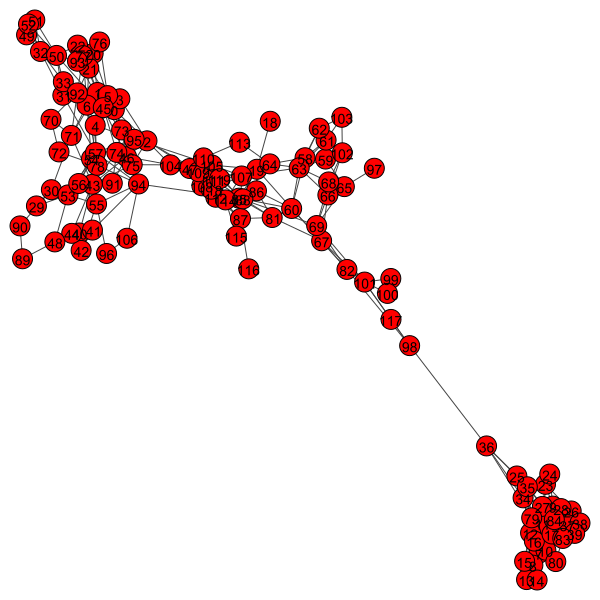

In [7]:
g= igraph.Graph.from_networkx(G)
igraph.plot(g,vertex_label=range(g.vcount()))
#igraph.plot(g,vertex_label=g.vs['_nx_name'])

In [8]:
for i in range(g.ecount()):
    #print(i)
    if len(raw_data.loc[(raw_data['userID']==g.vs[g.es[i].source]['_nx_name'])&(raw_data['friendID']==g.vs[g.es[i].target]['_nx_name'])]['weight'].values)>0:
        g.es[i]['weight'] = raw_data.loc[(raw_data['userID']==g.vs[g.es[i].source]['_nx_name'])&(raw_data['friendID']==g.vs[g.es[i].target]['_nx_name'])]['weight'].values[0]
    elif len(raw_data.loc[(raw_data['userID']==g.vs[g.es[i].target]['_nx_name'])&(raw_data['friendID']==g.vs[g.es[i].source]['_nx_name'])]['weight'].values)>0:
        g.es[i]['weight'] = raw_data.loc[(raw_data['userID']==g.vs[g.es[i].target]['_nx_name'])&(raw_data['friendID']==g.vs[g.es[i].source]['_nx_name'])]['weight'].values[0]

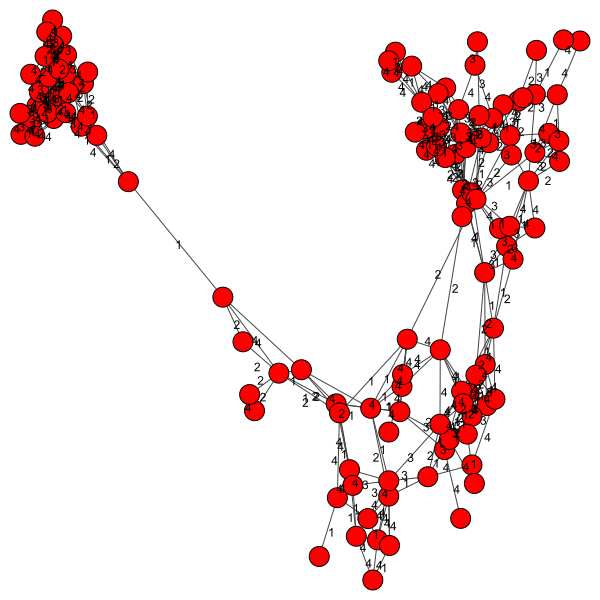

In [9]:
igraph.plot(g,edge_label=g.es['weight'])

In [10]:
g.vcount()

120

In [11]:
g.ecount()

348

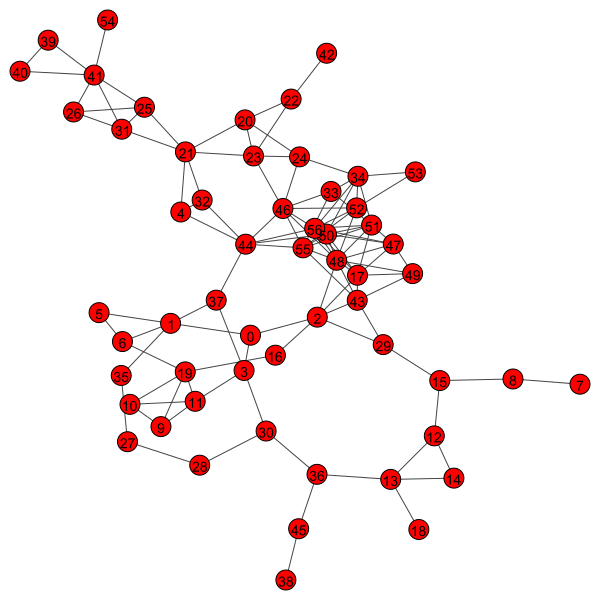

In [128]:
#G1 = nx.subgraph(G, list(G.nodes)[0:30])
G1 = nx.subgraph(G,random.sample(list(G.nodes),80))
G1 = nx.Graph(G1)
G1 = PreserveLargestConnectedGraph(G1)
g1 = igraph.Graph.from_networkx(G1)
#igraph.plot(g1,vertex_label=g1.vs['_nx_name'])
igraph.plot(g1,vertex_label=range(g1.vcount()))

In [129]:
g1.vcount()

57

In [130]:
g1.ecount()

114

In [131]:
#define the model for Node Location Design

In [132]:
N=g1.vcount()
M=g1.vcount()

In [133]:
N

57

In [134]:
# Define the model
model = LpProblem(name="node-location", sense=LpMinimize)

In [135]:
#constants
# cost of connecting area i to possible location j
#pre-calculated value, by different topology
cost_connect = g1.distances()
cost_open = np.ones(N)*10

In [136]:
# raw_data.loc[(raw_data['userID']==3)&(raw_data['friendID']==134)]

In [137]:
for i in range(N):
    for j in range(N):
        if cost_connect[i][j]>1:
            cost_connect[i][j] = 999
        if cost_connect[i][j] ==1:
            user_id = g1.vs[i]['_nx_name']
            friend_id = g1.vs[j]['_nx_name']
            #print(i,j,user_id,friend_id)
            if len(raw_data.loc[(raw_data['userID']==user_id)&(raw_data['friendID']==friend_id)])>0:
                cost_connect[i][j] = raw_data.loc[(raw_data['userID']==user_id)&(raw_data['friendID']==friend_id)]['weight'].values[0]
            elif len(raw_data.loc[(raw_data['userID']==friend_id)&(raw_data['friendID']==user_id)])>0:
                cost_connect[i][j] =raw_data.loc[(raw_data['userID']==friend_id)&(raw_data['friendID']==user_id)]['weight'].values[0]

In [138]:
count=0
for i in range(N):
    for j in range(N):
        if cost_connect[i][j]<999 and cost_connect[i][j]>1:
            #print(cost_connect[i][j])
            count+=1

In [139]:
count

169

In [140]:
#cost_connect

In [141]:
# Creates a list of tuples containing all the possible routes for nodes
Routes = [(i, j) for i in range(N) for j in range(M)]

In [142]:
# Define the decision variables
u = {(i,j): LpVariable(name=f"u{(i,j)}", cat='Binary') for i in range(N) for j in range(M)}
#u = LpVariable.dicts('Route',(range(N),range(M)), cat='Binary')

In [143]:
# Define the decision variables
r = {j: LpVariable(name=f"r{j}", cat='Binary')for j in range(M)}

In [144]:
#add objective function first
model += (
    lpSum(u[i,j]*cost_connect[i][j] for i in range(N) for j in range(M))+lpSum(cost_open[j]*r[j] for j in range(M)),
    'Sum of open and connect cost',
)

In [145]:
# Add constraints
for i in range(N):
    model += (
        lpSum(u[i,j] for j in range(M)) == 1,
        f"connected constraints_{i}",
    )
for j in range(M):
     model += (
        lpSum(u[i,j] for i in range(N)) <=r[j]*N,
        f"open node constraints_{j}",
    )

In [146]:
# Solve the optimization problem
start = timeit.default_timer()
status = model.solve()
stop = timeit.default_timer()
print('Time: ', stop - start)

Time:  0.257258400000012


In [147]:
# Get the results
print(f"status: {model.status}, {LpStatus[model.status]}")
print(f"objective: {model.objective.value()}")

status: 1, Optimal
objective: 224.0


In [148]:
#print connection
selected_edge_set = set()
for var in u.values():
    if var.value() == 1:
        print(f"{var.name}: {var.value()}")
        selected_edge_set.add((int(re.findall(r'\d+',var.name)[0]),int(re.findall(r'\d+',var.name)[1])))
        #print(re.findall(r'\d+',var.name))

u(0,_3): 1.0
u(1,_1): 1.0
u(2,_43): 1.0
u(3,_3): 1.0
u(4,_21): 1.0
u(5,_1): 1.0
u(6,_19): 1.0
u(7,_8): 1.0
u(8,_8): 1.0
u(9,_19): 1.0
u(10,_19): 1.0
u(11,_19): 1.0
u(12,_13): 1.0
u(13,_13): 1.0
u(14,_13): 1.0
u(15,_8): 1.0
u(16,_19): 1.0
u(17,_43): 1.0
u(18,_13): 1.0
u(19,_19): 1.0
u(20,_21): 1.0
u(21,_21): 1.0
u(22,_42): 1.0
u(23,_21): 1.0
u(24,_34): 1.0
u(25,_21): 1.0
u(26,_41): 1.0
u(27,_27): 1.0
u(28,_27): 1.0
u(29,_43): 1.0
u(30,_3): 1.0
u(31,_41): 1.0
u(32,_21): 1.0
u(33,_34): 1.0
u(34,_34): 1.0
u(35,_1): 1.0
u(36,_13): 1.0
u(37,_1): 1.0
u(38,_38): 1.0
u(39,_41): 1.0
u(40,_41): 1.0
u(41,_41): 1.0
u(42,_42): 1.0
u(43,_43): 1.0
u(44,_56): 1.0
u(45,_38): 1.0
u(46,_56): 1.0
u(47,_56): 1.0
u(48,_56): 1.0
u(49,_43): 1.0
u(50,_34): 1.0
u(51,_56): 1.0
u(52,_56): 1.0
u(53,_34): 1.0
u(54,_41): 1.0
u(55,_43): 1.0
u(56,_56): 1.0


In [149]:
r.values()

dict_values([r0, r1, r2, r3, r4, r5, r6, r7, r8, r9, r10, r11, r12, r13, r14, r15, r16, r17, r18, r19, r20, r21, r22, r23, r24, r25, r26, r27, r28, r29, r30, r31, r32, r33, r34, r35, r36, r37, r38, r39, r40, r41, r42, r43, r44, r45, r46, r47, r48, r49, r50, r51, r52, r53, r54, r55, r56])

In [150]:
#print open node:
selected_v_set = set()
for var in r.values():
    if var.value() == 1:
        print(f"{var.name}: {var.value()}")
        selected_v_set.add(int(re.findall(r'\d+',var.name)[0]))

r1: 1.0
r3: 1.0
r8: 1.0
r13: 1.0
r19: 1.0
r21: 1.0
r27: 1.0
r34: 1.0
r38: 1.0
r41: 1.0
r42: 1.0
r43: 1.0
r56: 1.0


In [151]:
selected_v_set

{1, 3, 8, 13, 19, 21, 27, 34, 38, 41, 42, 43, 56}

In [152]:
selected_v_neighbour_number = {}
for item in selected_v_set:
    selected_v_neighbour_number[item] = 0
for item in selected_edge_set:
    #print(item[0],item[1])
    selected_v_neighbour_number[item[1]]+=1

In [153]:
selected_v_neighbour_number

{1: 4,
 34: 5,
 3: 3,
 38: 2,
 8: 3,
 41: 6,
 42: 2,
 43: 6,
 13: 5,
 19: 6,
 21: 6,
 56: 7,
 27: 2}

In [154]:
selected_v_neighbour_number

{1: 4,
 34: 5,
 3: 3,
 38: 2,
 8: 3,
 41: 6,
 42: 2,
 43: 6,
 13: 5,
 19: 6,
 21: 6,
 56: 7,
 27: 2}

In [155]:
len(selected_v_set)

13

In [156]:
#g.get_eid(item[0], item[1])

In [157]:
color_set = ['blue','green','yellow','pink','purple','red','orange']

In [158]:
len(color_set)

7

In [159]:
color = dict()
count = 0
for item in selected_v_set:
    print(item,count)
    color[item]=color_set[count]
    count+=1
    count = count%len(color_set)

1 0
34 1
3 2
38 3
8 4
41 5
42 6
43 0
13 1
19 2
21 3
56 4
27 5


In [160]:
color

{1: 'blue',
 34: 'green',
 3: 'yellow',
 38: 'pink',
 8: 'purple',
 41: 'red',
 42: 'orange',
 43: 'blue',
 13: 'green',
 19: 'yellow',
 21: 'pink',
 56: 'purple',
 27: 'red'}

In [161]:
g1.vs["color"] = "red"
g1.es["color"] = "black"
g1.es['width'] = 1
for item in selected_edge_set:
    if item[0]!=item[1]:
        g1.es[g1.get_eid(item[0], item[1])]["color"] = color[item[1]]
        g1.es[g1.get_eid(item[0], item[1])]["width"] = 3
        g1.vs[item[0]]["color"] = color[item[1]]

In [162]:
g1.vs['size'] = 35
for item in selected_v_set:
    g1.vs[item]["color"] = color[item]
    g1.vs[item]["width"] = 60#selected_v_neighbour_number[item]*5+40#60

In [163]:
 g1.vs[1]

igraph.Vertex(<igraph.Graph object at 0x0000025999F58540>, 1, {'_nx_name': 28, 'color': 'blue', 'size': 35, 'width': 60})

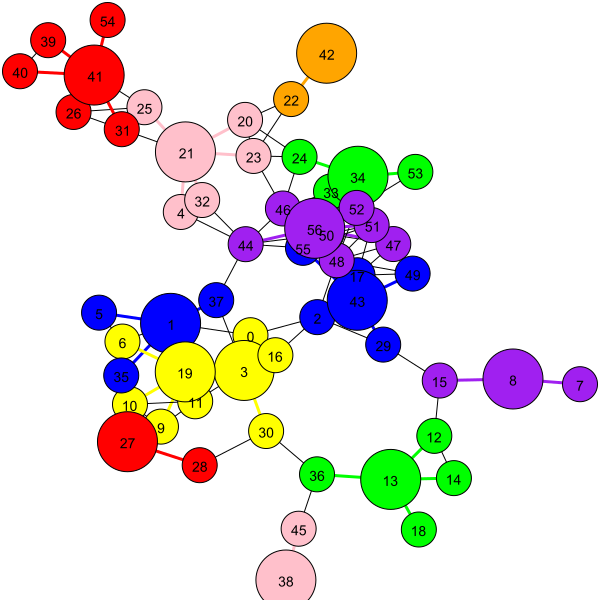

In [164]:
igraph.plot(g1,vertex_label=range(g1.vcount()))